In [88]:
!pip3 install -U scikit-fuzzy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 KB 6.9 MB/s eta 0:00:00m eta 0:00:010:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894068 sha256=89ce3da5a2a61862abbde947ee16118ae62821b0b8755cc6de0ffbbe9d463f5c
  Stored in directory: /home/junjie_chu/.cache/pip/wheels/32/2c/a1/a90a7d7dd8448ec029f298a61f3490275e99b17aa348be675c
Successfully built scikit-fuzzy


In [1]:
import random
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

In [2]:
# the simulated price table
# VCPU 
# 0-10: 0.2€/st 1 month
# 11-30: 0.1
# 31-90: 0.05
# RAM 
# 0-20: 0.1€/per GB month
# 21-60: 0.05
# 61-180: 0.025
# VOLUME：
# 0-100：0.02€/per GB 1 month
# 101-300：0.01€/per GB 1 month
# 301-900：0.005€/per GB 1 month

In [3]:
def visualize_parameter(x_range,y_range,requirement,ylabel):
    plt.figure()
    x = x_range
    y = y_range
    l1 = plt.plot(x, y, color='b',marker='o',linestyle='dashed',label='Provider proposal')
    #plt.axis([-5, x_range[-1]+5, requirement-10,  y_range[0]+10])
    plt.xlabel('round')
    plt.ylabel(ylabel)
    y_requirement = [requirement]*len(x_range)
    l2 = plt.plot(x, y_requirement, color='r',linestyle='dashed',label='Client requirement')
    plt.annotate('Last offer', xy=(x_range[-1],y_range[-1]), xytext=(x_range[-1],y_range[-1]-3),
            arrowprops=dict(facecolor='black',width=0.5, headwidth=7, shrink=0.005),
            )
    plt.legend()
    plt.show()

In [4]:
# Class for provider
class provider_base:
    min_change = [1, 1, 10]
    # input the initial number of vcpu,ram,volume
    def __init__(self, n_vcpu0 = 0, n_ram0 = 0, n_volume0 = 0):
        self.n_vcpu0 = n_vcpu0
        self.n_ram0 = n_ram0
        self.n_volume0 = n_volume0
        
    # Functions for controlling the value range of issues
    def vcpu_range(self,n):
        n_initial = 0
        if 0 < n <= 10:
            n_initial = 10+n
        elif 11 <= n <= 30:
            n_initial = 30+n
        elif 31 <= n <= 90:
            n_initial = n
        else:
            print('Out of Range!')
            return -1
        return n_initial

    def ram_range(self,n):
        n_initial = 0
        if 0 < n <= 20:
            n_initial = 20+n
        elif 21 <= n <= 60:
            n_initial = 60+n
        elif 61 <= n <= 180:
            n_initial = n
        else:
            print('Out of Range!')
            return -1
        return n_initial

    def volume_range(self,n):
        n_initial = 0
        if 0 < n <= 100:
            n_initial = 100+n
        elif 101 <= n <= 300:
            n_initial = 300+n
        elif 301 <= n <= 900:
            n_initial = n
        else:
            print('Out of Range!')
            return -1
        return n_initial

    def initial_offer(self,client_requirement):
        n_vcpu0 = self.vcpu_range(client_requirement[0])
        n_ram0 = self.ram_range(client_requirement[1])
        n_volume0 = self.volume_range(client_requirement[2])
        return n_vcpu0,n_ram0,n_volume0
    
    def compute_ratio(self,client_requirement):
        ratio = [int(i/client_requirement[0]) for i in client_requirement]
        times1round_vcpu = int(ratio[0]/provider_base.min_change[0])
        times1round_ram = int(ratio[1]/provider_base.min_change[1])
        times1round_volume = int(ratio[2]/provider_base.min_change[2])
        times1round = times1round_vcpu+times1round_ram+times1round_volume
        
        return times1round_vcpu,times1round_ram,times1round_volume,times1round
               
    def update_offer(self,times1round_vcpu,times1round_ram,times1round_volume,times1round,
                     n_vcpu0,n_ram0,n_volume0,
                     client_requirement):
        # like random gradient decent
        rand_int = random.randint(1,times1round)
        t1 = times1round_vcpu
        t2 = t1+times1round_ram
        t3 = t2+times1round_volume
        
        if 1<=rand_int<=t1:
            if n_vcpu0 > client_requirement[0]:
                n_vcpu0=n_vcpu0-provider_base.min_change[0]
            elif n_ram0 > client_requirement[1]:
                n_ram0=n_ram0-provider_base.min_change[1]
            elif n_volume0 > client_requirement[2]:
                n_volume0=n_volume0-provider_base.min_change[2]
                
        elif t1+1<=rand_int<=t2:
            if n_ram0 > client_requirement[1]:
                n_ram0=n_ram0-provider_base.min_change[1]
            elif n_volume0 > client_requirement[2]:
                n_volume0=n_volume0-provider_base.min_change[2]
            elif n_vcpu0 > client_requirement[0]:
                n_vcpu0=n_vcpu0-provider_base.min_change[0]
            
        elif t2+1<=rand_int<=t3:
            if n_volume0 > client_requirement[2]:
                n_volume0=n_volume0-provider_base.min_change[2]
            elif n_vcpu0 > client_requirement[0]:
                n_vcpu0=n_vcpu0-provider_base.min_change[0]
            elif n_ram0 > client_requirement[1]:
                n_ram0=n_ram0-provider_base.min_change[1]            
            
        return n_vcpu0,n_ram0,n_volume0        

In [5]:
# Class for client
class client_base:
    def __init__(self, client_requirement):
        self.requirement = client_requirement
              
    def compute_fee(self, p1, p2, p3, t1, t2, n):
        fee = 0
        if 0 < n <= t1:
            fee = p1*n
        elif t1 < n <= t2:
            fee = p1*t1+p2*(n-t1)
        elif t2 < n :
            fee = p1*t1+p2*(t2-t1)+p3*(n-t2)
        else:
            print('Out of Range!')
            return -1
        return fee
    
    def compute_avg_price(self, fee, num):
        return fee/num
    
    def compute_total_fee(self, f1, f2, f3):
        return f1+f2+f3
    
    def scale2one_avg(self, obj, old, new):
        ratio = new/old
        # the avg price ratio
        # new/old: the cheaper, the better
        # ratio: close to 0 is better, close to 1 is worse
        if obj == 'avg':
            return ratio
        # the total fee ratio
        # new total fee is always larger than old total fee
        # ratio is larger than 1, the larger the worse
        # the reciproval is between o and 1. the closer to 0, the worse
        # the closer to 1, the better
        elif obj == 'total':
            return 1/ratio
    
    def related_fee(self, client_requirement = None):
        
        if client_requirement == None:
            client_requirement = self.requirement
            
        vcpu_fee_r = self.compute_fee(0.2,0.1,0.05,10,30,client_requirement[0])
        vcpu_avg_r = self.compute_avg_price(vcpu_fee_r,client_requirement[0])
        ram_fee_r = self.compute_fee(0.1,0.05,0.025,20,60,client_requirement[1])
        ram_avg_r = self.compute_avg_price(ram_fee_r,client_requirement[1])
        volume_fee_r = self.compute_fee(0.02,0.01,0.005,100,300,client_requirement[2])
        volume_avg_r = self.compute_avg_price(volume_fee_r,client_requirement[2])
        total_fee_r = vcpu_fee_r+ram_fee_r+volume_fee_r
        return vcpu_avg_r,ram_avg_r,volume_avg_r,total_fee_r
    
    def fuzzy_decision(self):
        # Fuzzy logic

        # New Antecedent/Consequent objects hold universe variables and membership functions
        avg_vcpu = ctrl.Antecedent(np.arange(0, 101, 1), 'avg_vcpu')
        avg_ram = ctrl.Antecedent(np.arange(0, 101, 1), 'avg_ram')
        avg_volume = ctrl.Antecedent(np.arange(0, 101, 1), 'avg_volume')
        total_fee = ctrl.Antecedent(np.arange(0, 101, 1), 'total_fee')

        tendency = ctrl.Consequent(np.arange(0, 101, 1), 'tendency')

        # Auto-membership function population is possible with .automf(3, 5, or 7)
        # poor average good, automatically
        #names_avg = ['cheap','medium','expensive']
        #avg_vcpu.automf(names = names_avg)
        #avg_ram.automf(names = names_avg)
        #avg_volume.automf(names = names_avg)
        avg_vcpu['cheap'] = fuzz.gaussmf(avg_vcpu.universe, 0, 50.0/3)
        avg_vcpu['medium'] = fuzz.gaussmf(avg_vcpu.universe, 50, 50.0/3)
        avg_vcpu['expensive'] = fuzz.gaussmf(avg_vcpu.universe, 100, 50.0/3)

        avg_ram['cheap'] = fuzz.gaussmf(avg_ram.universe, 0, 50.0/3)
        avg_ram['medium'] = fuzz.gaussmf(avg_ram.universe, 50, 50.0/3)
        avg_ram['expensive'] = fuzz.gaussmf(avg_ram.universe, 100, 50.0/3)

        avg_volume['cheap'] = fuzz.gaussmf(avg_volume.universe, 0, 50.0/3)
        avg_volume['medium'] = fuzz.gaussmf(avg_volume.universe, 50, 50.0/3)
        avg_volume['expensive'] = fuzz.gaussmf(avg_volume.universe, 100, 50.0/3)

        #names_total = ['high','medium','low']
        #total_fee.automf(names = names_total)
        total_fee['high'] = fuzz.gaussmf(total_fee.universe, 0, 50.0/3)
        total_fee['medium'] = fuzz.gaussmf(total_fee.universe, 50, 50.0/3)
        total_fee['low'] = fuzz.gaussmf(total_fee.universe, 100, 50.0/3)

        # Custom membership functions can be built interactively with a familiar,
        # Pythonic API
        tendency['low'] = fuzz.gaussmf(tendency.universe, 0, 50.0/3)
        tendency['medium'] = fuzz.gaussmf(tendency.universe, 50, 50.0/3)
        tendency['high'] = fuzz.gaussmf(tendency.universe, 100, 50.0/3)
        
        # Rules
        # cheap:1,medium:2,expensive:3
        # sum: 3, 4, 5, 6, 7, 8, 9
        # tendency: 3, 4 high / 5, 6 ,7 medium / 8, 9 low
        # could be adjusted
        rule01 = ctrl.Rule(total_fee['high'], tendency['low'])
        rule02 = ctrl.Rule(total_fee['medium'], tendency['medium'])
        rule03 = ctrl.Rule(total_fee['low'], tendency['high'])
        
        rule11 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['cheap']&avg_ram['cheap'], tendency['high'])#3
        rule12 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['cheap']&avg_ram['medium'], tendency['high'])#4
        rule13 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['cheap']&avg_ram['expensive'], tendency['medium'])#5
        rule14 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['medium']&avg_ram['cheap'], tendency['high'])#4
        rule15 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['medium']&avg_ram['medium'], tendency['medium'])#5
        rule16 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['medium']&avg_ram['expensive'], tendency['medium'])#6
        rule17 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['expensive']&avg_ram['cheap'], tendency['medium'])#5
        rule18 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['expensive']&avg_ram['medium'], tendency['medium'])#6
        rule19 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['expensive']&avg_ram['expensive'], tendency['medium'])#7
        
        rule21 = ctrl.Rule(avg_vcpu['medium']&avg_volume['cheap']&avg_ram['cheap'], tendency['high'])#4
        rule22 = ctrl.Rule(avg_vcpu['medium']&avg_volume['cheap']&avg_ram['medium'], tendency['medium'])#5
        rule23 = ctrl.Rule(avg_vcpu['medium']&avg_volume['cheap']&avg_ram['expensive'], tendency['medium'])#6
        rule24 = ctrl.Rule(avg_vcpu['medium']&avg_volume['medium']&avg_ram['cheap'], tendency['medium'])#5
        rule25 = ctrl.Rule(avg_vcpu['medium']&avg_volume['medium']&avg_ram['medium'], tendency['medium'])#6
        rule26 = ctrl.Rule(avg_vcpu['medium']&avg_volume['medium']&avg_ram['expensive'], tendency['medium'])#7
        rule27 = ctrl.Rule(avg_vcpu['medium']&avg_volume['expensive']&avg_ram['cheap'], tendency['medium'])#6
        rule28 = ctrl.Rule(avg_vcpu['medium']&avg_volume['expensive']&avg_ram['medium'], tendency['medium'])#7
        rule29 = ctrl.Rule(avg_vcpu['medium']&avg_volume['expensive']&avg_ram['expensive'], tendency['low'])#8
        
        rule31 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['cheap']&avg_ram['cheap'], tendency['medium'])#5
        rule32 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['cheap']&avg_ram['medium'], tendency['medium'])#6
        rule33 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['cheap']&avg_ram['expensive'], tendency['medium'])#7
        rule34 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['medium']&avg_ram['cheap'], tendency['medium'])#6
        rule35 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['medium']&avg_ram['medium'], tendency['medium'])#7
        rule36 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['medium']&avg_ram['expensive'], tendency['low'])#8
        rule37 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['expensive']&avg_ram['cheap'], tendency['medium'])#7
        rule38 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['expensive']&avg_ram['medium'], tendency['low'])#8
        rule39 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['expensive']&avg_ram['expensive'], tendency['low'])#9

        
        # Fuzzy decision simulation
        decision_ctrl = ctrl.ControlSystem([rule01, rule02, rule03, \
                                            rule11, rule12, rule13, rule14, rule15, rule16, rule17, rule18, rule19, \
                                            rule21, rule22, rule23, rule24, rule25, rule26, rule27, rule28, rule29, \
                                            rule31, rule32, rule33, rule34, rule35, rule36, rule37, rule38, rule39, \
                                           ])
        decision = ctrl.ControlSystemSimulation(decision_ctrl)
        
        return decision,tendency
        

# The simulated price table
## VCPU 
0-10: 0.2€/st 1 day  
11-30: 0.1  
31-90: 0.05  
## RAM 
0-20: 0.1€/per GB day  
21-60: 0.05  
61-180: 0.025  
## VOLUME：
0-100：0.02€/per GB 1 day  
101-300：0.01€/per GB 1 day  
301-900：0.005€/per GB 1 day  

In [6]:
def negotiation_client_bool(client_requirements):
    max_rounds = 150
    
    # Client
    # order: CPU-st, RAM-GB, VOLUME-GB
    #client_requirement = [10, 20, 200] 
    client = client_base(client_requirement)
    client_decision,tendency = client.fuzzy_decision()
    # Provider
    provider = provider_base()
    offer = provider.initial_offer(client_requirement)
    times1round_vcpu,times1round_ram,times1round_volume,times1round = provider.compute_ratio(client_requirement)

    # Original price, i.e. baseline
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old = client.related_fee()
    #print('*********************************************************************')
    #print('Client requirement: ', client_requirement)
    #print('vcpu_avg_price: %f, ram_avg_price: %f, volume_avg_price: %f'%(vcpu_avg_old,ram_avg_old,volume_avg_old))
    #print('total_fee: %f'%total_fee_old)
    #print('*********************************************************************')
    # For plotting
    steps = [];vcpu = [];ram = [];volume = [];avg_vcpu = [];avg_ram = [];avg_volume = [];total_fee = []
    #print('Provider first offer: ',offer)
    i = 0
    while True:
        # New fees
        vcpu_avg_new,ram_avg_new,volume_avg_new,total_fee_new = client.related_fee(offer)
        # Store offer and fee
        steps.append(i);vcpu.append(offer[0]);ram.append(offer[1]);volume.append(offer[2])
        avg_vcpu.append(vcpu_avg_new);avg_ram.append(ram_avg_new);avg_volume.append(volume_avg_new);total_fee.append(total_fee_new)
        # input of fuzzy system
        input_avg_vcpu = 100*client.scale2one_avg('avg', vcpu_avg_old, vcpu_avg_new)
        input_avg_ram = 100*client.scale2one_avg('avg', ram_avg_old, ram_avg_new)
        input_avg_volume = 100*client.scale2one_avg('avg', volume_avg_old, volume_avg_new)
        input_total_fee = 100*client.scale2one_avg('total', total_fee_old, total_fee_new)
        dict_of_data = {'avg_vcpu':input_avg_vcpu,'avg_ram':input_avg_ram,'avg_volume':input_avg_volume,'total_fee':input_total_fee}
        #dict_of_data = {'avg_vcpu':5,'avg_ram':5,'avg_volume':5,'total_fee':2}
        #print(dict_of_data)

        # Client makes decision
        client_decision.inputs(dict_of_data)
        # Crunch the numbers
        client_decision.compute()
        decision_score = client_decision.output['tendency']
        #print('---------------------------------------------------------------')
        #print('offer %d: '%i , offer, ' its score: ',decision_score)
        #print('vcpu_avg_price: %f, ram_avg_price: %f, volume_avg_price: %f'%(vcpu_avg_new,ram_avg_new,volume_avg_new))
        #print('total_fee: %f'%total_fee_new)
        #print('---------------------------------------------------------------')

        # if accepet
        if decision_score >= 50:
            final_offer = offer
            #print('This final offer is ',final_offer)
            break
        # if reject  
        else:
            if offer[0]>=client_requirement[0] and offer[1]>=client_requirement[1] and offer[2]>=client_requirement[2]:
                if offer[0]==client_requirement[0] and offer[1]==client_requirement[1] and offer[2]==client_requirement[2]:
                    final_offer = offer
                    break
                else:
                    #offer = (10, 23, 230)
                    offer = provider.update_offer(times1round_vcpu,times1round_ram,times1round_volume,times1round,
                                              offer[0],offer[1],offer[2],
                                             client_requirement)
                #print(offer)
            else:
                final_offer = offer
                #print('Round:',i,'break!')
                #print('The final offer is the last offer!')
                break
        
        i = i+1
        if i > max_rounds:
            final_offer = offer
            #print('Round %d'%i,' . Reach the MAX round!')
            #print('Last offer (also the final offer): ' , final_offer, ' its score: ',decision_score)
            #print('vcpu_avg_price: %f, ram_avg_price: %f, volume_avg_price: %f'%(vcpu_avg_new,ram_avg_new,volume_avg_new))
            #print('total_fee: %f'%total_fee_new)       
            break
        
    #print(i,' rounds')
                
    return steps,vcpu,ram,volume,vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,avg_vcpu,avg_ram,avg_volume,total_fee,final_offer

# Single test

In [7]:
random.seed(19260817)
vcpu = 10
ram = 20
volume = 200
client_requirement = [vcpu, ram, volume]
time_start=time.time()
steps,vcpu,ram,volume,\
vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
avg_vcpu,avg_ram,avg_volume,total_fee,\
final_offer = negotiation_client_bool(client_requirement)
time_end=time.time()
print('time cost',time_end-time_start,'s')

time cost 0.29624509811401367 s


In [8]:
len(steps)

27

In [9]:
final_offer

(10, 34, 400)

# Generate test data set

In [17]:
random.seed(19260817)
x_test = pd.read_csv('./data/offer_ML/x_test_200_v1.csv',index_col=0).reset_index(drop=True)

In [18]:
test_final_offer_list = []
for index,row in tqdm(x_test.iterrows(),total=x_test.shape[0]):
    vcpu=row['vcpu']
    ram=row['ram']
    volume=row['volume']    
    client_requirement = [vcpu, ram, volume]
    steps,vcpu,ram,volume,\
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
    avg_vcpu,avg_ram,avg_volume,total_fee,\
    final_offer = negotiation_client_bool(client_requirement)
    final_offer_dict = {'final_vcpu':final_offer[0], 'final_ram':final_offer[1], 'final_volume':final_offer[2]}
    test_final_offer_list.append(final_offer_dict)
y_test = pd.DataFrame(test_final_offer_list)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:40<00:00,  4.89it/s]


In [19]:
y_test.to_csv('./data/offer_ML/v00_y_test_200_v1.csv')

In [20]:
y_test.columns=['Name','Age','Roll_no']
x_test.columns=['Name','Age','Roll_no']

In [ ]:
from pandas.testing import assert_frame_equal
assert_frame_equal(x_test,y_test)

In [156]:
x_test

,Name,Age,Roll_no
0,5,25,400
1,7,35,220
2,7,54,400
3,7,56,320
4,7,56,520
...,...,...,...
195,47,122,660
196,47,138,700
197,47,164,720
198,48,111,820


In [157]:
y_test

,Name,Age,Roll_no
0,5,25,400
1,7,35,220
2,7,54,400
3,7,56,320
4,7,56,520
...,...,...,...
195,47,122,660
196,47,138,700
197,47,164,720
198,48,111,820


## Train size = 10000

In [10]:
x_train_104 = pd.read_csv('./data/offer_ML/x_train_104_v1.csv',index_col=0).reset_index(drop=True)

In [11]:
train_final_offer_list = []
for index,row in tqdm(x_train_104.iterrows(),total=x_train_104.shape[0]):
    vcpu=row['vcpu']
    ram=row['ram']
    volume=row['volume']    
    client_requirement = [vcpu, ram, volume]
    steps,vcpu,ram,volume,\
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
    avg_vcpu,avg_ram,avg_volume,total_fee,\
    final_offer = negotiation_client_bool(client_requirement)
    final_offer_dict = {'final_vcpu':final_offer[0], 'final_ram':final_offer[1], 'final_volume':final_offer[2]}
    train_final_offer_list.append(final_offer_dict)
y_train_104 = pd.DataFrame(train_final_offer_list)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [35:52<00:00,  4.64it/s]


In [12]:
y_train_104.to_csv('./data/offer_ML/v00_y_train_104_v1.csv')

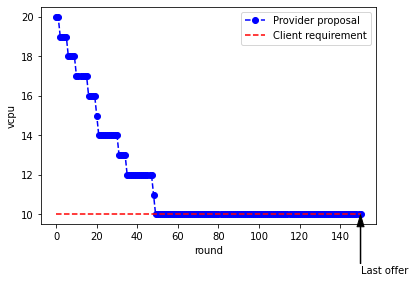

In [79]:
visualize_parameter(steps,vcpu,client_requirement[0],'vcpu')

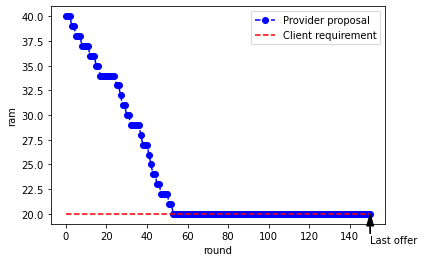

In [80]:
visualize_parameter(steps,ram,client_requirement[1],'ram')

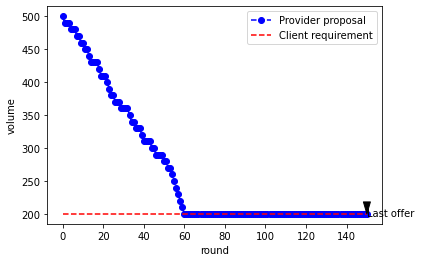

In [81]:
visualize_parameter(steps,volume,client_requirement[2],'volume')